In [ ]:
### 1. IMPORT LIBRARIES
from pathlib import Path 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import re




ROOT = Path(__file__).resolve().parent

In [ ]:
### 2. READ DATA
print(f"Importing files from {ROOT}")
X_raw = pd.read_csv(ROOT / 'x_train.csv')
y_raw = pd.read_csv(ROOT / 'y_train.csv')
X_final = pd.read_csv(ROOT / 'x_test.csv')

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'object':
            df[col] = df[col].astype('category')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
    return df
 
X_raw = optimize_memory(X_raw)
y_raw = optimize_memory(y_raw)
X_final = optimize_memory(X_final)

Importing files from G:\My Drive\Cours\EDHEC\M2\data_science\hw


<ipython-input-37-d17d34eff346>:4: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_raw = pd.read_csv(ROOT / 'x_train.csv')
<ipython-input-37-d17d34eff346>:6: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_final = pd.read_csv(ROOT / 'x_test.csv')


Shape of the Dataset :  (383610, 377)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Columns: 377 entries, ID to ZONE
dtypes: category(280), float32(39), int32(58)
memory usage: 244.4 MB
None


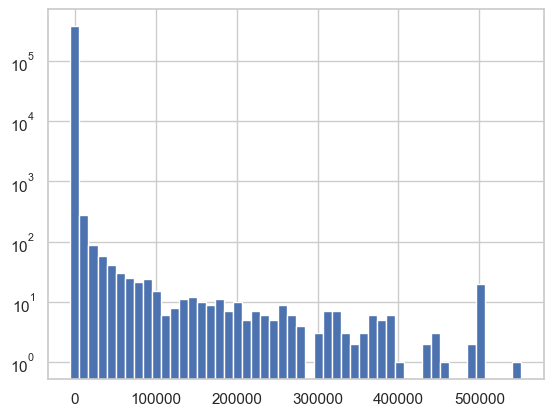

In [ ]:
df = pd.merge(y_raw, X_raw)

print("Shape of the Dataset : ",df.shape)
print(df.info())

plt.hist(df['CHARGE'], bins=50)
plt.yscale('log')

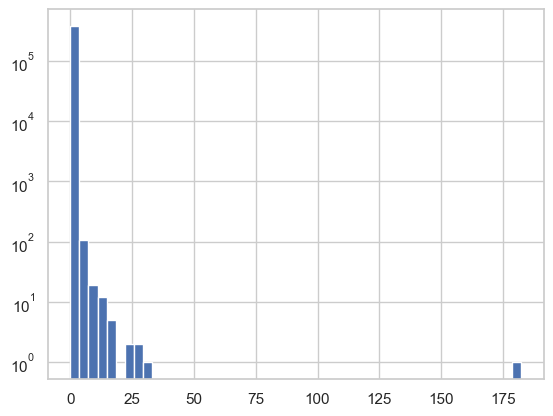

In [ ]:
plt.hist(df['FREQ'], bins=50)
plt.yscale('log')

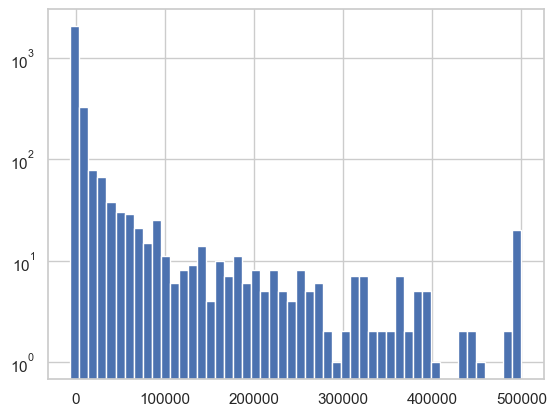

In [ ]:
plt.hist(df[df['FREQ'] != 0]['CM'], bins=50)
plt.yscale('log')

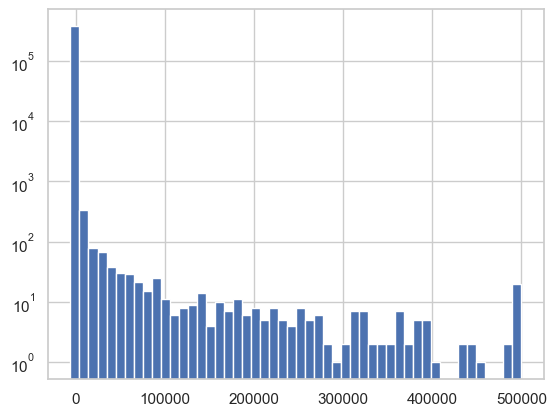

In [ ]:
plt.hist(df['CM'], bins=50)
plt.yscale('log')

Démarrage de l'extraction des signaux...
Entraînement du modèle Fréquence (sur 100% des données)...


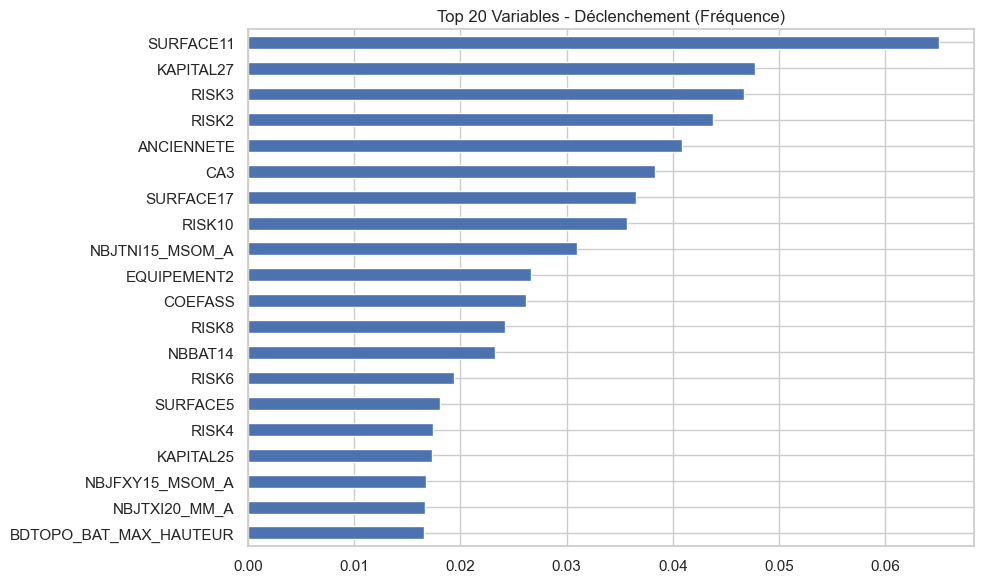

Entraînement du modèle Sévérité (uniquement sur les sinistres > 0)...


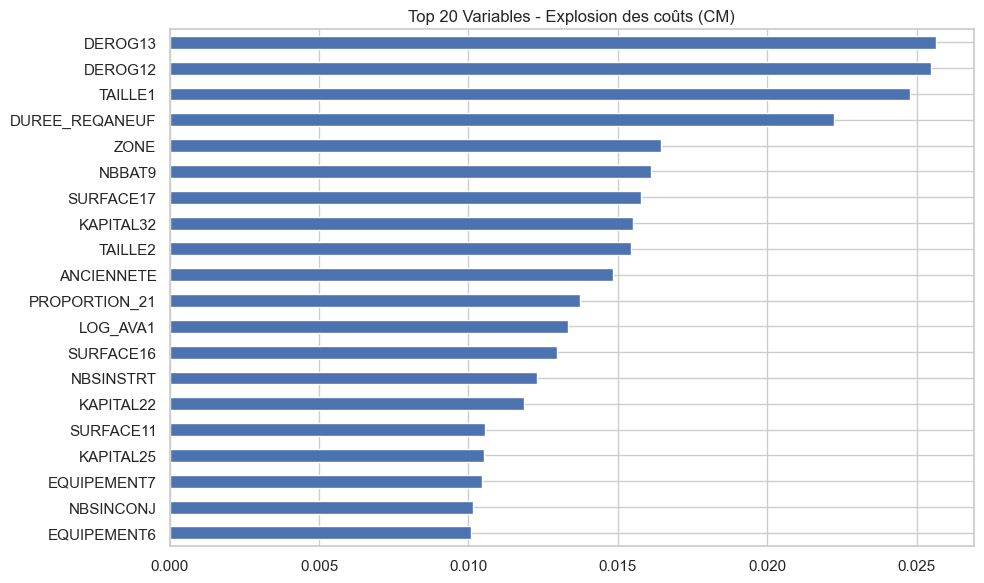


Nombre total de variables uniques à analyser dans l'EDA visuelle : 36


In [ ]:
X = X_raw.copy()
y = y_raw.copy()

# 1. PRÉPARATION COMMUNE
# On supprime les variables inutiles et l'année d'exercice (qui est une fuite temporelle)
X_clean = X.drop(columns=['ID', 'ANNEE_ASSURANCE', 'AN_EXERC'], errors='ignore')

# On force les objets en string pour éviter le plantage de l'OrdinalEncoder
cat_cols_to_cast = X_clean.select_dtypes(exclude=np.number).columns
X_clean[cat_cols_to_cast] = X_clean[cat_cols_to_cast].astype(str)

# Pipeline de preprocessing "brutal"
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), make_column_selector(dtype_exclude=np.number))
    ]
)

# Fonction utilitaire pour extraire et plotter les importances
def plot_importances(pipeline, title):
    num_cols = pipeline.named_steps['preprocessor'].transformers_[0][2]
    cat_cols = pipeline.named_steps['preprocessor'].transformers_[1][2]
    all_cols = num_cols + cat_cols
    importances = pipeline.named_steps['model'].feature_importances_
    feat_imp = pd.Series(importances, index=all_cols).sort_values(ascending=False).head(20)
    
    plt.figure(figsize=(10, 6))
    feat_imp.plot(kind='barh')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    return feat_imp.index.tolist()

print("Démarrage de l'extraction des signaux...")

# --- MODÈLE 1 : LE DÉTECTEUR DE FRÉQUENCE ---
print("Entraînement du modèle Fréquence (sur 100% des données)...")
rf_freq = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
pipeline_freq = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_freq)])

pipeline_freq.fit(X_clean, y['FREQ'])
top_20_freq = plot_importances(pipeline_freq, "Top 20 Variables - Déclenchement (Fréquence)")


# --- MODÈLE 2 : LE DÉTECTEUR DE SÉVÉRITÉ (COÛT) ---
print("Entraînement du modèle Sévérité (uniquement sur les sinistres > 0)...")
# LA RÈGLE D'OR : On ampute le dataset des lignes sans sinistre
mask_sinistres = y['FREQ'] > 0
X_sinistres = X_clean[mask_sinistres]
y_cout_moyen = y.loc[mask_sinistres, 'CM']

rf_cout = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
pipeline_cout = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_cout)])

pipeline_cout.fit(X_sinistres, y_cout_moyen)
top_20_cout = plot_importances(pipeline_cout, "Top 20 Variables - Explosion des coûts (CM)")

# --- BILAN ---
top_global = list(set(top_20_freq + top_20_cout))
print(f"\nNombre total de variables uniques à analyser dans l'EDA visuelle : {len(top_global)}")

c:\Users\piere\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


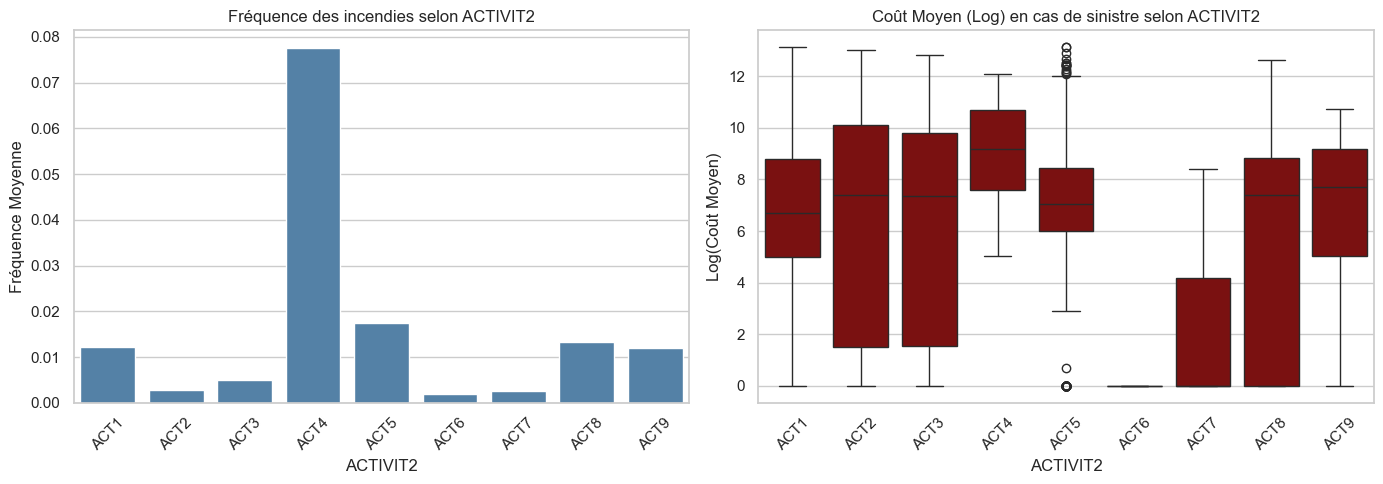

In [ ]:
# Style épuré pour rapport professionnel
sns.set_theme(style="whitegrid")

def analyse_categorielle(df, colonne_cat):
    """
    Autopsie d'une variable catégorielle (ex: ACTIVIT2, ZONE)
    Génère 2 graphiques : Impact sur la Fréquence, Impact sur le Coût.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Le Détecteur de Fréquence
    # sns.barplot calcule automatiquement la moyenne de FREQ par catégorie
    sns.barplot(data=df, x=colonne_cat, y='FREQ', ax=axes[0], color='steelblue', errorbar=None)
    axes[0].set_title(f"Fréquence des incendies selon {colonne_cat}")
    axes[0].set_ylabel("Fréquence Moyenne")
    axes[0].tick_params(axis='x', rotation=45)
    
    # 2. Le Détecteur de Sévérité (UNIQUEMENT SI FEU)
    mask_feu = df['FREQ'] > 0
    df_feu = df[mask_feu].copy()
    df_feu['LOG_CM'] = np.log1p(df_feu['CM']) # On écrase les valeurs extrêmes pour y voir clair
    
    sns.boxplot(data=df_feu, x=colonne_cat, y='LOG_CM', ax=axes[1], color='darkred')
    axes[1].set_title(f"Coût Moyen (Log) en cas de sinistre selon {colonne_cat}")
    axes[1].set_ylabel("Log(Coût Moyen)")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyse_numerique(df, colonne_num, q=4):
    """
    Autopsie d'une variable numérique (ex: SURFACE, TAILLE1)
    Découpe la variable en 'q' tranches (quantiles) pour voir l'escalade du risque.
    """
    # On crée des "bacs" pour regrouper les valeurs numériques
    df_temp = df.copy()
    # qcut gère les quantiles. Si la variable a trop de zéros, cut est parfois préférable
    try:
        df_temp['TRANCHES'] = pd.qcut(df_temp[colonne_num], q=q, duplicates='drop')
    except:
        df_temp['TRANCHES'] = pd.cut(df_temp[colonne_num], bins=q)
        
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Escalade de la Fréquence
    sns.barplot(data=df_temp, x='TRANCHES', y='FREQ', ax=axes[0], color='steelblue', errorbar=None)
    axes[0].set_title(f"Escalade de la Fréquence selon {colonne_num}")
    axes[0].set_ylabel("Fréquence Moyenne")
    axes[0].tick_params(axis='x', rotation=45)
    
    # 2. Escalade du Coût
    mask_feu = df_temp['FREQ'] > 0
    df_feu = df_temp[mask_feu].copy()
    df_feu['LOG_CM'] = np.log1p(df_feu['CM'])
    
    sns.boxplot(data=df_feu, x='TRANCHES', y='LOG_CM', ax=axes[1], color='darkred')
    axes[1].set_title(f"Escalade du Coût (Log) selon {colonne_num}")
    axes[1].set_ylabel("Log(Coût Moyen)")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

analyse_categorielle(df, 'ACTIVIT2')

c:\Users\piere\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


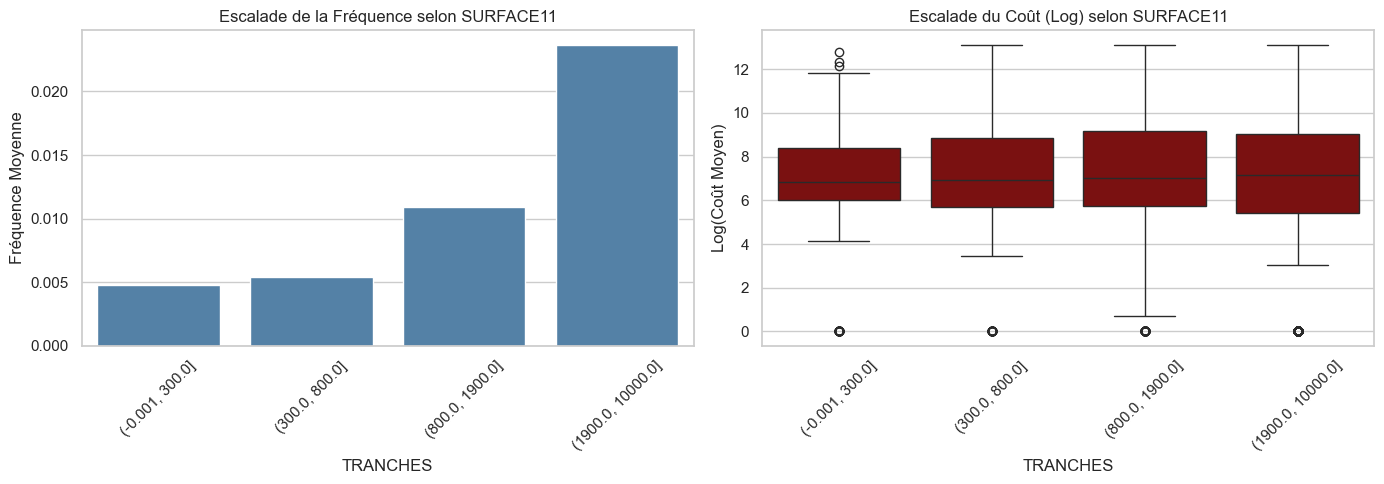

In [ ]:
analyse_numerique(df, 'SURFACE11')

c:\Users\piere\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


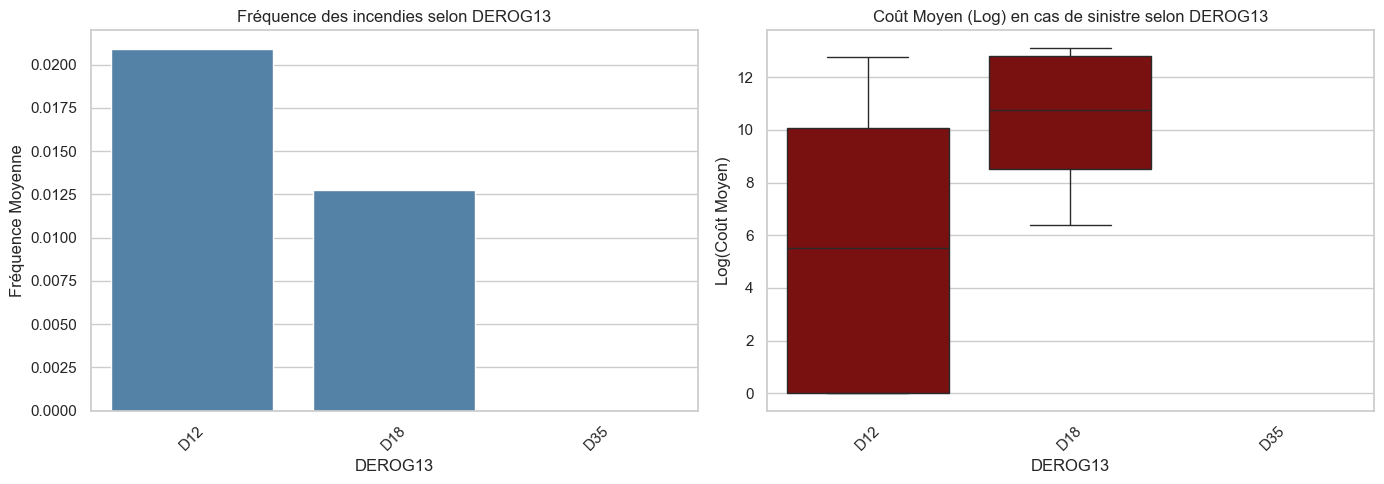

In [ ]:
analyse_categorielle(df, 'DEROG13')